In [9]:
import matplotlib.pyplot as plt
import numpy as np

def read_QEwavfunc(filename: str):
    """
    Reads a Quantum ESPRESSO wave function file and extracts relevant data.

    Parameters:
    -----------
    filename : str
        The path to the Quantum ESPRESSO wave function file (usually with extension `wfc*.dat`).

    Returns:
    --------
    tuple
        A tuple containing the following elements:
        
        evc : ndarray
            A complex array of shape (nbnd, npol*igwx) containing the wave function coefficients for each band.
        
        ik : int
            The k-point index.
        
        xk : ndarray
            A float array of shape (3,) containing the k-point coordinates.
        
        ispin : int
            Spin component (1 for up, -1 for down)
        
        gamma_only : bool
            A boolean flag indicating if the calculation is gamma-point only.
        
        scalef : float
            Scaling factor for wavefunctions
        
        ngw : int
            The number of G-vectors/Number of grid points.
        
        igwx : int
            The extended number of G-vectors/Number of plane waves in one direction (used for FFT).
        
        npol : int
            The number of polarizations (usually related to spin).
        
        nbnd : int
            The number of bands.
        
        b1, b2, b3 : ndarray
            Float arrays of shape (3,) representing the reciprocal lattice vectors/ Unit cell information (b1, b2, b3).
        
        mill : ndarray
            An integer array of shape (igwx, 3) containing the Miller indices of the G-vectors.

    Notes:
    ------
    This function is intended to be used with Quantum ESPRESSO wave function files and extracts
    relevant data for further processing, such as plotting or calculation of matrix elements.

    The binary format of the wave function file is specific to Quantum ESPRESSO and may change
    between different versions. Ensure compatibility with the version of Quantum ESPRESSO used
    to generate the file.

    Example:
    --------
    >>> evc, ik, xk, ispin, gamma_only, scalef, ngw, igwx, npol, nbnd, b1, b2, b3, mill = read_QEwavfunc('path_to_wave_function_file.wfc')
    """
    with open(filename, 'rb') as f:
        # Moves the cursor 4 bytes to the right
        f.seek(4)

        ik = np.fromfile(f, dtype='int32', count=1)[0]
        xk = np.fromfile(f, dtype='float64', count=3)
        ispin = np.fromfile(f, dtype='int32', count=1)[0]
        gamma_only = bool(np.fromfile(f, dtype='int32', count=1)[0])
        scalef = np.fromfile(f, dtype='float64', count=1)[0]

        # Move the cursor 8 bytes to the right
        f.seek(8, 1)

        ngw = np.fromfile(f, dtype='int32', count=1)[0]
        igwx = np.fromfile(f, dtype='int32', count=1)[0]
        npol = np.fromfile(f, dtype='int32', count=1)[0]
        nbnd = np.fromfile(f, dtype='int32', count=1)[0]

        # Move the cursor 8 bytes to the right
        f.seek(8, 1)

        b1 = np.fromfile(f, dtype='float64', count=3)
        b2 = np.fromfile(f, dtype='float64', count=3)
        b3 = np.fromfile(f, dtype='float64', count=3)

        f.seek(8, 1)

        mill = np.fromfile(f, dtype='int32', count=3 * igwx)
        mill = mill.reshape((igwx, 3))

        evc = np.zeros((nbnd, npol * igwx), dtype="complex128")

        f.seek(8, 1)
        for i in range(nbnd):
            evc[i, :] = np.fromfile(f, dtype='complex128', count=npol * igwx)
            f.seek(8, 1)
            
        return evc, ik, xk, ispin, gamma_only, scalef, ngw, igwx, npol, nbnd, b1, b2, b3, mill
    
def calculate_transition_matrix(evc_initial, evc_final, operator):
    """
    Calculate the transition matrix elements between initial and final wave functions using a given operator.

    Parameters:
    -----------
    evc_initial : ndarray
        The initial wave function coefficients.
    
    evc_final : ndarray
        The final wave function coefficients.
    
    operator : ndarray
        The operator matrix used for calculating transition elements.

    Returns:
    --------
    complex
        The transition matrix element.
    """
    # Ensure the operator is correctly dimensioned
    assert operator.shape == (evc_initial.shape[0], evc_initial.shape[0]), "Operator shape mismatch."

    # Compute the transition matrix elements
    transition_matrix = np.vdot(evc_initial, np.dot(operator, evc_final))
    return transition_matrix

def plot_WavFunc(evc_band: list, band_index: int):
    """
    Plots the magnitude of the wave function coefficients for a given band.

    Parameters:
    -----------
    evc_band : list
        A list or array-like object containing the wave function coefficients for a specific band.
        The coefficients are typically complex numbers.
        
    band_index : int
        An integer, index of the band which is returned as ik

    Returns:
    --------
    None

    This function generates a plot of the magnitudes of the wave function coefficients
    (|coefficient|) against their G-vector indices.

    Example:
    --------
    >>> evc_band = [1+1j, 2+2j, 3+3j, 4+4j]  # Example wave function coefficients
    >>> plot_WavFunc(evc_band)

    Notes:
    ------
    - The input `evc_band` should be a list or an array-like object containing complex or real numbers.
    - The plot shows the magnitude of each coefficient, which is calculated using `np.abs`.
    - This function is useful for visualizing the distribution of wave function coefficients in a specific band.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(np.abs(evc_band), 'o')
    plt.xlabel('G-vector index')
    plt.ylabel('Magnitude of eigenvector coefficient')
    plt.title(f'Wavefunction Coefficients for Band {band_index}')
    plt.show()

Shape of evc: (26, 3832)
Shape of first wave function: (3832,)
Transition matrix elements: (-9.51845512131566e-10-3.513694125586997e-09j)


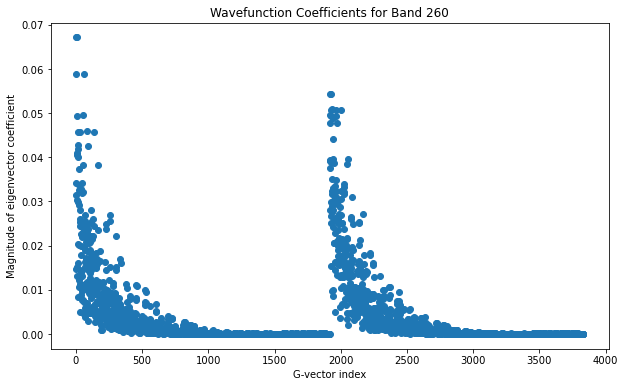

In [14]:
# Example usage
band_index = 260
filename = f'./GaAs.save/wfc{band_index}.dat'
# Load wave function data
evc, ik, xk, ispin, gamma_only, scalef, ngw, igwx, npol, nbnd, b1, b2, b3, mill = read_QEwavfunc(filename)

# Print shapes for debugging
print(f"Shape of evc: {evc.shape}")
print(f"Shape of first wave function: {evc[0].shape}")

# Example operator (identity matrix for simplicity)
operator = np.eye(igwx * npol)

# Calculate transition matrix for the first and second bands as an example
transition_matrix = calculate_transition_matrix(evc[0], evc[1], operator)
print("Transition matrix elements:", transition_matrix)

# Plotting the magnitude of the wave function coefficients for the first band
plot_WavFunc(evc[0], ik)


In [28]:
for i in range(nbnd):
    plot_WavFunc(evc[i], ik)

# Garbage

In [26]:
import numpy as np

def create_real_space_wavefunc(evc, b1, b2, b3, mill, ngw, igwx, npol, nbnd):
    """
    Converts wave function coefficients from reciprocal space to real space.

    Parameters:
    -----------
    evc : ndarray
        A complex array of shape (nbnd, npol*igwx) containing the wave function coefficients for each band.
    
    b1, b2, b3 : ndarray
        Float arrays of shape (3,) representing the reciprocal lattice vectors.
    
    mill : ndarray
        An integer array of shape (igwx, 3) containing the Miller indices of the G-vectors.
    
    ngw : int
        The number of G-vectors.
    
    igwx : int
        The extended number of G-vectors.
    
    npol : int
        The number of polarizations (usually related to spin).
    
    nbnd : int
        The number of bands.

    Returns:
    --------
    real_space_wf : ndarray
        A complex array representing the wave function in real space.
    """
    # Calculate the grid dimensions from the number of G-vectors
    nx = int(np.rint(ngw**(1/3)))
    ny = nx
    nz = nx

    real_space_wf = np.zeros((nbnd, npol, nx, ny, nz), dtype="complex128")

    # Loop over each band and polarization
    for band in range(nbnd):
        for pol in range(npol):
            # Reshape the coefficients for FFT
            evc_band_pol = evc[band, pol*igwx:(pol+1)*igwx]
            
            # Create a 3D grid for reciprocal space coefficients
            reciprocal_grid = np.zeros((nx, ny, nz), dtype="complex128")
            
            # Populate the grid with the coefficients
            for idx, gvec in enumerate(mill):
                reciprocal_grid[gvec[0] % nx, gvec[1] % ny, gvec[2] % nz] = evc_band_pol[idx]
            
            # Perform the inverse FFT to get real space wave function
            real_space_wf[band, pol] = np.fft.ifftn(reciprocal_grid) * np.prod([nx, ny, nz])
    
    return real_space_wf

# Example usage
# Load wave function data
evc, ik, xk, ispin, gamma_only, scalef, ngw, igwx, npol, nbnd, b1, b2, b3, mill = read_QEwavfunc(filename)

# Convert to real space wave function
real_space_wf = create_real_space_wavefunc(evc, b1, b2, b3, mill, ngw, igwx, npol, nbnd)

# real_space_wf is now a 5D array with shape (nbnd, npol, nx, ny, nz)
print(real_space_wf.shape)


(26, 2, 13, 13, 13)


In [23]:
import numpy as np

def wavefunc_to_real_space(evc, b1, b2, b3, mill, ng, igwx):
    """
    Converts wave function coefficients from reciprocal space to real space.

    Parameters:
    -----------
    evc : ndarray
        A complex array of shape (nbnd, npol*igwx) containing the wave function coefficients for each band.
        
    b1, b2, b3 : ndarray
        Float arrays of shape (3,) representing the reciprocal lattice vectors.
        
    mill : ndarray
        An integer array of shape (igwx, 3) containing the Miller indices of the G-vectors.
        
    ng : int
        The number of grid points in real space.
        
    igwx : int
        The extended number of G-vectors.
    
    Returns:
    --------
    real_space_wavfunc : ndarray
        A complex array of shape (ng, ng, ng) representing the wave function in real space.
    """
    # Create the grid in real space
    x = np.linspace(0, 1, ng, endpoint=False)
    y = np.linspace(0, 1, ng, endpoint=False)
    z = np.linspace(0, 1, ng, endpoint=False)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    real_space_wavfunc = np.zeros((ng, ng, ng), dtype=complex)

    for i in range(igwx):
        G = mill[i, 0] * b1 + mill[i, 1] * b2 + mill[i, 2] * b3
        phase = np.exp(2j * np.pi * (G[0] * X + G[1] * Y + G[2] * Z))
        real_space_wavfunc += evc[:i][:, np.newaxis, np.newaxis, np.newaxis] * phase

    return real_space_wavfunc

# Example usage
evc, ik, xk, ispin, gamma_only, scalef, ngw, igwx, npol, nbnd, b1, b2, b3, mill = read_QEwavfunc(filename)
ng = 8  # Example grid size in real space
real_space_wavfunc = wavefunc_to_real_space(evc[0], b1, b2, b3, mill, ng, igwx)


ValueError: non-broadcastable output operand with shape (8,8,8) doesn't match the broadcast shape (0,8,8,8)

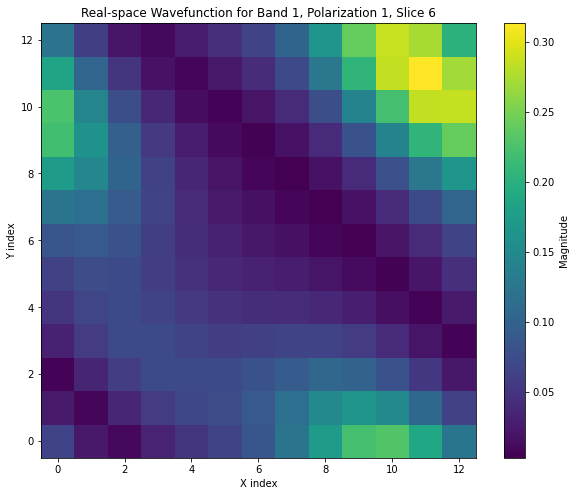

In [27]:
def plot_real_space_wavefunc(real_space_wf, band=0, pol=0, slice_idx=None):
    """
    Plots the real-space wave function for a specified band and polarization.

    Parameters:
    -----------
    real_space_wf : ndarray
        A complex array representing the wave function in real space.
    
    band : int, optional
        The band index to plot. Default is 0.
    
    pol : int, optional
        The polarization index to plot. Default is 0.
    
    slice_idx : int, optional
        The index of the slice to plot along the z-axis. If None, the middle slice is used. Default is None.

    Returns:
    --------
    None
    """
    # Select the specified slice or the middle slice by default
    if slice_idx is None:
        slice_idx = real_space_wf.shape[3] // 2
    
    # Extract the specified band and polarization
    wavefunc_slice = real_space_wf[band, pol, :, :, slice_idx]
    
    # Plot the magnitude of the wave function in real space
    plt.figure(figsize=(10, 8))
    plt.imshow(np.abs(wavefunc_slice), origin='lower', cmap='viridis')
    plt.colorbar(label='Magnitude')
    plt.title(f'Real-space Wavefunction for Band {band+1}, Polarization {pol+1}, Slice {slice_idx}')
    plt.xlabel('X index')
    plt.ylabel('Y index')
    plt.show()

# Example usage
# Load wave function data
evc, ik, xk, ispin, gamma_only, scalef, ngw, igwx, npol, nbnd, b1, b2, b3, mill = read_QEwavfunc(filename)

# Convert to real space wave function
real_space_wf = create_real_space_wavefunc(evc, b1, b2, b3, mill, ngw, igwx, npol, nbnd)

# Plot the real-space wave function for the first band and first polarization
plot_real_space_wavefunc(real_space_wf, band=0, pol=0)